<a href="https://colab.research.google.com/github/OnurcanKoken/TensorFlow_Workshops_Colab_General_Usage/blob/master/Data_Augmentation/Data_Augmentation_Male_Infertility.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Görüntü Verisi Çoğaltma - Image Data Augmentation**

---



# 1. Kütüphaneleri Tanımlayalım ve Verileri Alalım

In [ ]:
# Mounting Google Drive locally
# Import Google Drive Files and the Dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Selection of tensorflow version
try:
  %tensorflow_version 2.x
except Exception:
  pass

In [ ]:
# import the libraries that will be used
import os
import cv2
import keras
import random
import numpy as np
from PIL import Image
from numpy import save
import tensorflow as tf
from numpy import expand_dims
from matplotlib import pyplot
import matplotlib.pyplot as plt
from scipy import ndimage, misc
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img 
!pip install -q keras


In [ ]:
# Load the dataset
# Note that the augmetation performs only on the training dataset!
x_128_train = '/content/drive/My Drive/AI/Male_Infertility_Assessment/MHSMA The Modified Human Sperm Morphology Analysis Dataset-20201116T105219Z-001/mhsma-dataset-master/mhsma/x_128_train.npy'
img_x_128_train = np.load(x_128_train) # load the dataset as a numpy array


Here I want to show that we can plot the images in an image format or in a numpy array format, it is all up to us. You can see how to convert them to each other below.

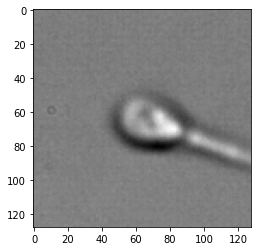

In [ ]:
# check one of the images
# copy the image not to disturb the original one
img_0_arr = (img_x_128_train[0]).copy() 

# convert the image from array to image format
img_0 = Image.fromarray(img_0_arr)

# convert the image from image to array format
img_0_arr = np.asarray(img_0)

# plt.imshow(img_0_arr, cmap='gray', vmin=0, vmax=255) # optional
# plot numpy array format as an image
plt.imshow(img_0_arr, cmap='gray')
# plt.show() # optional

We could do the same as follows;

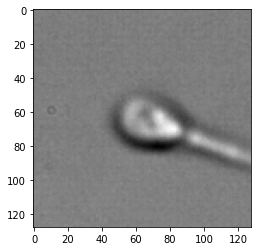

In [ ]:
# get a numpy array image and plot
img_0 = (img_x_128_train[0]).copy() 
plt.imshow(img_0, cmap = 'gray')

# 2. Fonksiyonlarımı Tanımlayalım

**INPUT 128 x 128 image**

- Rotate

- Shift

- Flip

- Brightness

- Crop 128 x 128 to 64 x 64 image

- Normalization

**OUTPUT 64 x 64 image**

# 2.1 Rotate [0, 360) degree randomly

In [ ]:
import scipy
# rotate image [0,360) degree by nearest-neighbor algorithm
def rotate_img(image, degree):

    image = scipy.ndimage.interpolation.rotate(image, degree, reshape = False, mode='nearest')

    return image


In [ ]:
# this one is an alternative to rotate by using the Image Data Generator
# rotate image [0,360) degree by nearest-neighbor algorithm
def alternative_rotate_img(image, degree):

    datagen = ImageDataGenerator(rotation_range = degree) 
    img_rotate = img_to_array(image) 
    img_rotate = img_rotate.reshape((1, ) + img_rotate.shape)  

    i=0
    for img_batch in datagen.flow(img_rotate, batch_size=1):
      for img_rotate in img_batch:
          img_rotate = np.squeeze(img_rotate, axis = 2)
          img_rotate = np.asarray(img_rotate)
          #plt.imshow(img_rotate, cmap='gray', vmin=0, vmax=255)
          #plt.show()
          i=i+1    
      if i >= 1: # limits the number of rotated images
          break

    return img_rotate


# 2.2 Shift [-5, +5] pixels horizontal and/or vertical randomly

Note that the directions are with respect to the image, not to user's aspect!
- shift_left()
- shift_right()
- shift_up()
- shift_down()
- shift_all()

In [ ]:

# Shifting Left
def shift_left(image, pxl):
  # WIDTH = 128  HEIGHT = 128
  WIDTH, HEIGHT = image.shape
  for i in range(HEIGHT, 1, -1):
    for j in range(WIDTH):
      if (i < HEIGHT-pxl):
        image[j][i] = image[j][i-pxl]
  return image

# Shifting Right
def shift_right(image, pxl):
  # WIDTH = 128  HEIGHT = 128
  WIDTH, HEIGHT = image.shape
  for j in range(WIDTH):
    for i in range(HEIGHT):
      if (i < HEIGHT-pxl):
        image[j][i] = image[j][i+pxl]
  return image

# Shifting Up
def shift_up(image, pxl):
  # WIDTH = 128  HEIGHT = 128
  WIDTH, HEIGHT = image.shape
  for j in range(WIDTH):
    for i in range(HEIGHT):
      if (j < WIDTH - pxl and j > pxl):
        image[j][i] = image[j+pxl][i]
      #else: # this can be used instead of overwriting on the image
        # image[j][i] = 1
  return image

# Shifting Down
def shift_down(image, pxl):
  # WIDTH = 128  HEIGHT = 128
  WIDTH, HEIGHT = image.shape
  for j in range(WIDTH, 1, -1):
    for i in range(HEIGHT):
      if (j < HEIGHT - pxl and j > pxl):
        image[j][i] = image[j-pxl][i]
  return image

# Shift randomly
def shift_all(image):

  v = random.randint(0, 1)
  if v == 1:
    image = shift_up(image, random.randint(0, 5))
  if v == 0:
    image = shift_down(image, random.randint(0, 5))

  h = random.randint(0, 1)
  if h == 1:
    image = shift_right(image, random.randint(0, 5))
  if h == 0:
    image = shift_left(image, random.randint(0, 5))
  
  return image


# 2.3 Flip horizontal and/or vertical randomly

In [ ]:
# flip vertical and/or horizontal
def flip_vh(image):
  h = random.randint(0, 1)
  y = random.randint(0, 1)
  if (h == 1):
    image = np.flipud(image) # up down
  if (y == 1):
    image = np.fliplr(image) # left right
  return image

# 2.4 Brightness -> multiply the image by e^(random([-log(1,25),+log(1,25)])) 

In [ ]:
# exp^log(1.25) brigthness
def brigth1_25(image):
  x = np.log10(1.25)
  y = random.uniform(-x,x)
  image = (np.exp(y))*image
  return image

# 2.4.1 Check if the Brightness Function Works

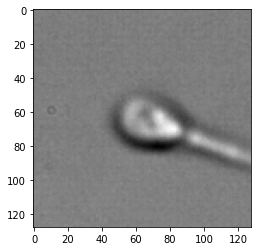

In [ ]:
# plot the original one
# get a numpy array image and plot
img_0 = (img_x_128_train[0]).copy() 
plt.imshow(img_0, cmap = 'gray')

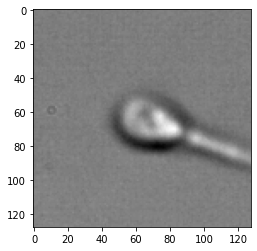

In [ ]:
# plot the manipulated one
img_0 = (img_x_128_train[0]).copy() 
img_0 = brigth1_25(img_0)
# get a numpy array image and plot
plt.imshow(img_0, cmap = 'gray')

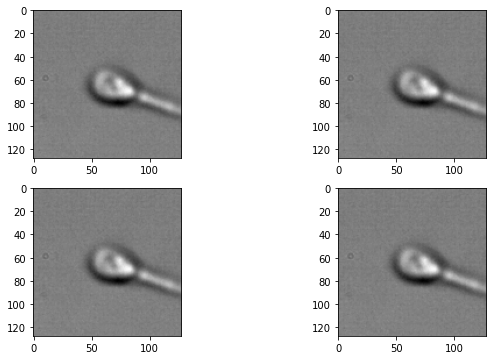

In [ ]:
img_0 = (img_x_128_train[0]).copy() 
f, axarr = plt.subplots(2,2, figsize = (10,6))
axarr[0,0].imshow(brigth1_25(img_0), cmap = 'gray')
axarr[0,1].imshow(brigth1_25(img_0), cmap = 'gray')
axarr[1,0].imshow(brigth1_25(img_0), cmap = 'gray')
axarr[1,1].imshow(brigth1_25(img_0), cmap = 'gray')

It is hard to clarify by looking these images wheter the brightness function works or not, so that it is better to check if they are equal mathematically

In [ ]:
print(brigth1_25(img_0) == brigth1_25(img_0))

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


Since the equality returns False for each parameter, it can seen that the images are not the same

In [ ]:
print((img_0) == (img_0))

[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


# 2.5 Crop 128 x 128 to 64 x 64

In [ ]:
# SizeAndCut: 128x128 to 64x64
def SizeAndCut(img):
  new_img = np.zeros((64,64))
  for i in range(0,96):
   for j in range(0,96):
     if 32 <= i <= 95:
       if 32 <= j <= 95:
          new_img[i-32,j-32] = img[i,j]

  return new_img

# 2.6 Normalization

In [ ]:
# normalize img by substruct mean of it and divide by 255
def norm_img(img):
  img_norm = (img - np.mean(img)) / 255
  return img_norm

# 3. Data Augmentation

In [ ]:
  def data_augmentation_image(image):

    # rotate [0,360)
    image = rotate_img(image, random.randint(0, 359))

    # shift +-5 horizontal or vertical
    image = shift_all(image)

    # flip horizontal and/or vertical
    image = flip_vh(image)

    # brightness
    image = brigth1_25(image)

    # 128x128 to 64x64
    image = SizeAndCut(image)

    # normalization
    image = norm_img(image)

    return image

# 3.1 Check if the Data Augmentation Function Works 

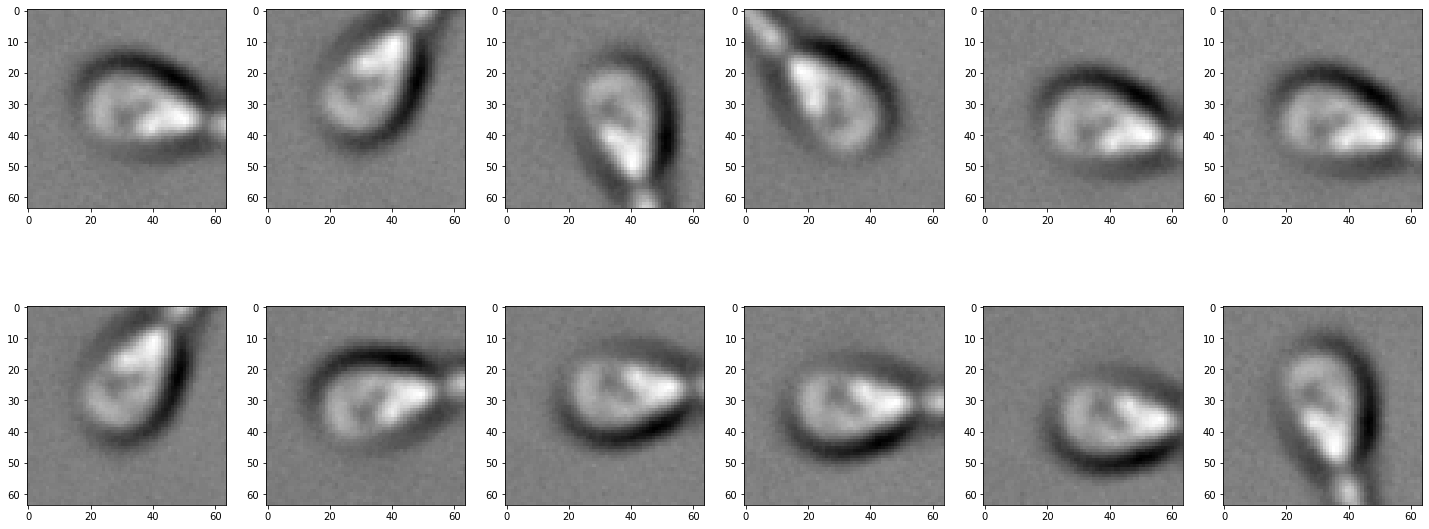

In [ ]:
img_0 = (img_x_128_train[0]).copy() 
f, axarr = plt.subplots(2,6, figsize = (25,10))
axarr[0,0].imshow(data_augmentation_image(img_0), cmap = 'gray')
axarr[0,1].imshow(data_augmentation_image(img_0), cmap = 'gray')
axarr[0,2].imshow(data_augmentation_image(img_0), cmap = 'gray')
axarr[0,3].imshow(data_augmentation_image(img_0), cmap = 'gray')
axarr[0,4].imshow(data_augmentation_image(img_0), cmap = 'gray')
axarr[0,5].imshow(data_augmentation_image(img_0), cmap = 'gray')
axarr[1,0].imshow(data_augmentation_image(img_0), cmap = 'gray')
axarr[1,1].imshow(data_augmentation_image(img_0), cmap = 'gray')
axarr[1,2].imshow(data_augmentation_image(img_0), cmap = 'gray')
axarr[1,3].imshow(data_augmentation_image(img_0), cmap = 'gray')
axarr[1,4].imshow(data_augmentation_image(img_0), cmap = 'gray')
axarr[1,5].imshow(data_augmentation_image(img_0), cmap = 'gray')